In [1]:
#Import Turing, Distributions, StatsBase, DataFrames and CSV
using Turing, Distributions, StatsBase, DataFrames, CSV

# Import MCMCChain, Plots and StatsPlots
using MCMCChains, Plots, StatsPlots

# Set a seed for reproducibility.
using Random
Random.seed!(12);

# Turn off progress monitor.
Turing.turnprogress(false)

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /home/saumya/.julia/packages/Turing/eIa7P/src/Turing.jl:24


false

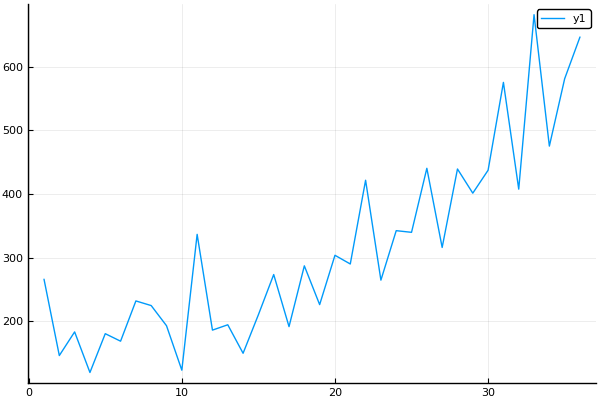

In [2]:
# Load in the shampoo dataset (can be downloaded from https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv)
df = CSV.read("../data/shampoo.csv")
s = df.Sales
pyplot()
plot(s)

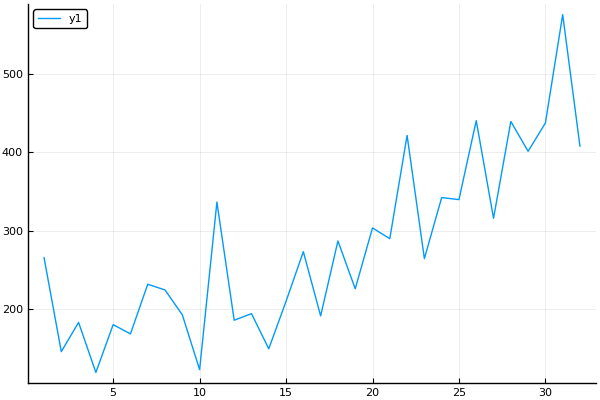

In [3]:
# Split into training and test sets. We will predict for the next 4 days using the data from the past 32 days
train_percentage = 0.9
s_train = s[1:floor(Int, train_percentage*length(s))]
N = length(s_train)

# Plot the training data
plot(s_train)

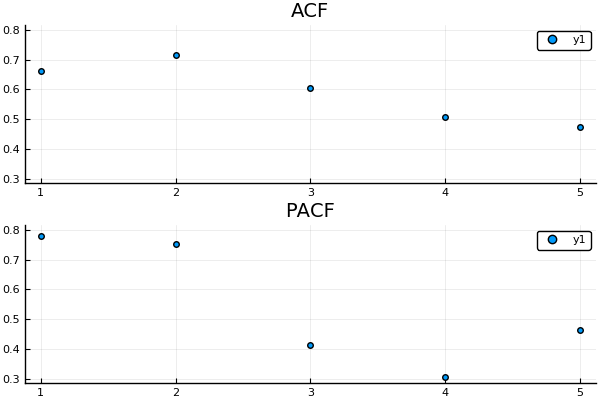

In [4]:
#Plot ACF and PACF plots
s1 = scatter([1, 2, 3, 4, 5], autocor(s, [1, 2, 3, 4, 5]), title = "ACF", ylim = [0.3,0.8])
s2 = scatter([1, 2, 3, 4, 5], pacf(s, [1, 2, 3, 4, 5]), title = "PACF", ylim = [0.3,0.8])
plot(s1, s2, layout = (2, 1))
# The PACF plot cuts off at k = 2, so we will have an AR(2) model for this dataset.

In [5]:
#Defining the model
σ = 1.0
@model AR(x, N) = begin
    α ~ Normal(0,σ) 
    beta_1 ~ Uniform(-1, 1)
    beta_2 ~ Uniform(-1, 1)
    for t in 3:N
        μ = α + beta_1 * x[t-1] + beta_2 * x[t - 2] 
        x[t] ~ Normal(μ, 0.1) 
    end
end;

In [6]:
# Sample using NUTS(n_iters::Int, n_adapts::Int, δ::Float64), where:
# n_iters::Int : The number of samples to pull.
# n_adapts::Int : The number of samples to use with adapatation.
# δ::Float64 : Target acceptance rate.

chain = sample(AR(s_train, N), NUTS(5000, 200, 0.65) )

┌ Info: Found initial step size
│   init_ϵ = 0.0001953125
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/eIa7P/src/inference/hmc.jl:364
┌ Info: Finished 200 adapation steps
│   adaptor = StanHMCAdaptor(n_adapts=200, pc=DiagPreconditioner, ssa=NesterovDualAveraging(γ=0.05, t_0=10.0, κ=0.75, δ=0.65, state.ϵ=0.019322295966155645), init_buffer=75, term_buffer=50)
│   τ.integrator = Leapfrog(ϵ=0.0193)
│   h.metric = DiagEuclideanMetric([0.00504295, 9.11098e-5, 9. ...])
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/sampler.jl:67
┌ Info: Finished 5000 sampling steps in 3.29264269 (s)
│   h = Hamiltonian(metric=DiagEuclideanMetric([0.00504295, 9.11098e-5, 9. ...]))
│   τ = NUTS{Multinomial,Generalised}(integrator=Leapfrog(ϵ=0.0193), max_depth=5), Δ_max=1000.0)
│   EBFMI(Hs) = 483.8610282514137
│   mean(αs) = 0.7934105994608782
└ @ AdvancedHMC /home/saumya/.julia/packages/AdvancedHMC/hAEIX/src/sampler.jl:77


Object of type Chains, with data of type 4800×13×1 Array{Union{Missing, Float64},3}

Log evidence      = 0.0
Iterations        = 1:4800
Thinning interval = 1
Chains            = 1
Samples per chain = 4800
internals         = eval_num, lp, acceptance_rate, hamiltonian_energy, is_accept, log_density, n_steps, numerical_error, step_size, tree_depth
parameters        = beta_1, α, beta_2

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 2 columns
│ Row │ parameters │ mean     │ std        │ naive_se   │ mcse        │
│     │ Symbol     │ Float64  │ Float64    │ Float64    │ Float64     │
├─────┼────────────┼──────────┼────────────┼────────────┼─────────────┤
│ 1   │ beta_1     │ 0.283806 │ 0.0023381  │ 3.37475e-5 │ 0.000313015 │
│ 2   │ beta_2     │ 0.675943 │ 0.00452598 │ 6.53269e-5 │ 0.00060629  │
│ 3   │ α          │ 26.6504  │ 2.04084    │ 0.029457   │ 0.27391     │

Quantiles

│ Row │ parameters │ 2.5%     │ 25.0%    │ 50.0%    │ 75.0%    │ 97.5%    │
│     │

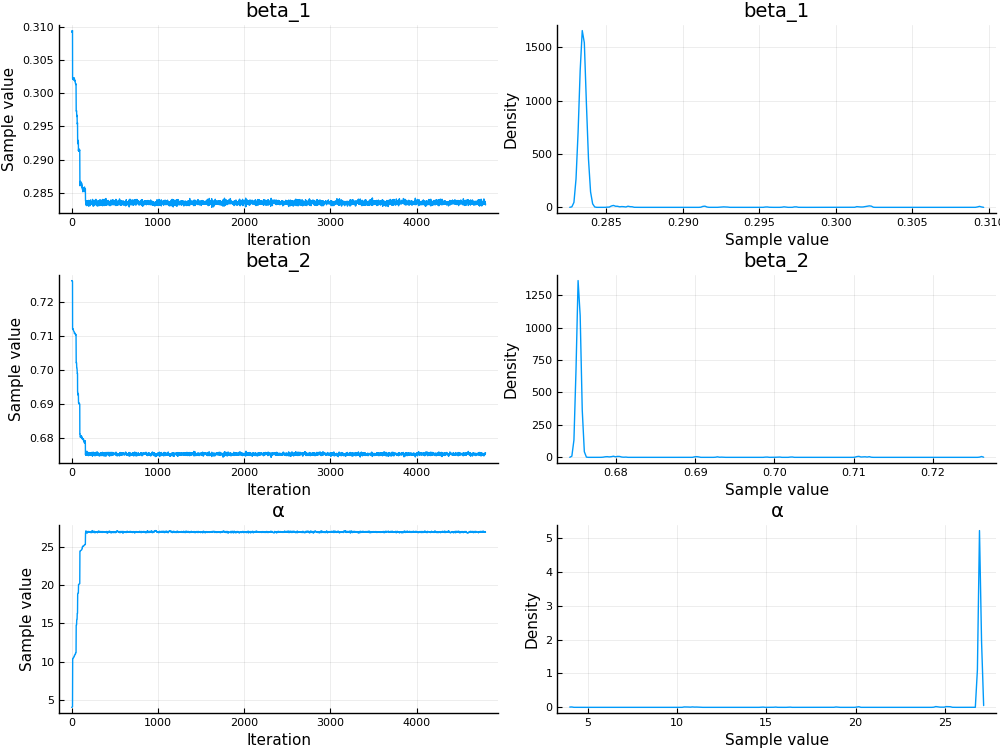

In [7]:
# Chain has been sampled; Now let us visualise it!
plot(chain)

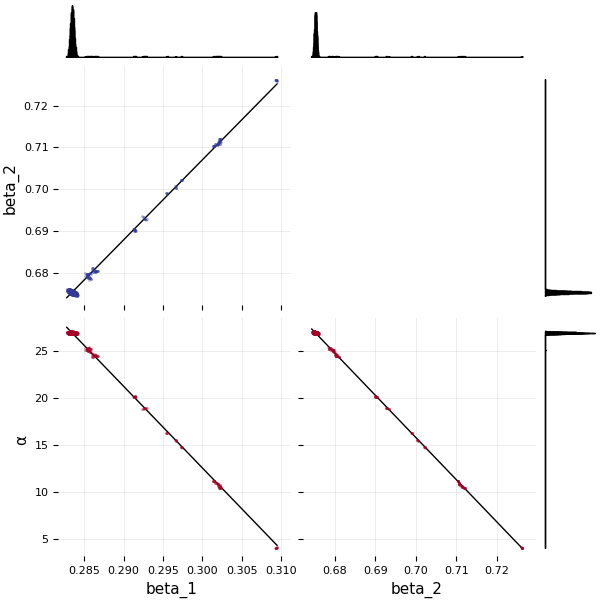

In [8]:
#Plotting the corner plot for the chain
corner(chain)

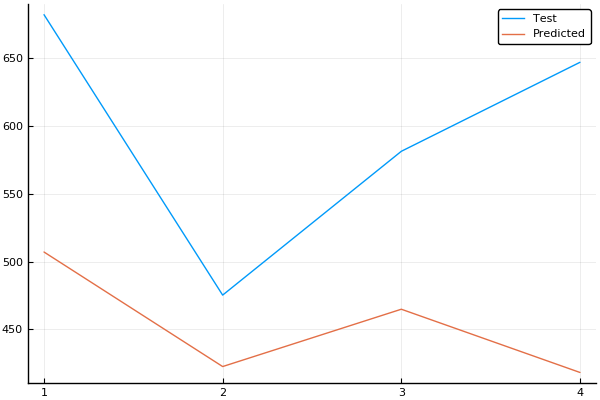

In [9]:
#Removing the warmup samples
chains_new = chain[50:4800]

# Getting the mean values of the sampled parameters
beta_1 = mean(chains_new[:beta_1].value)
beta_2 = mean(chains_new[:beta_2].value)

#Obtaining the test data
s_test = s[N + 1:length(s)]

#Obtaining the predicted results using the AR(2) definition
s_pred = Float64[]
first_ele =  s_train[N]*beta_1 + s_train[N - 1]*beta_2 + rand(Normal(0,1))
push!(s_pred, first_ele)
second_ele = s_pred[1]*beta_1 + s_train[N]*beta_2 + rand(Normal(0,1))
push!(s_pred, second_ele)
for i=3:length(s_test)
    next_ele = s_pred[i - 1]*beta_1 + s_pred[i - 2]*beta_2 + rand(Normal(0,1))
    push!(s_pred, next_ele)
end

#Plotting the test and the predicted data for comparison
plot(s_test, label = "Test")
plot!(s_pred, label = "Predicted")